## Fixed, Random Effects and Mundlak Machines


In this notebook we reproduce the fantastic material from the video [Statistical Rethinking 2026 Lecture B04 - Group-level confounding and intro to social networks](https://www.youtube.com/watch?v=XNNcN8sU8us) by Richard McElreath. This is a great video to understand the difference between fixed and random effects models. It is a must watch! Here we use Bambi to fit the models and compare the results.

**Remark**: This notebook was adapted from the original blog post in PyMC: ["Fixed and Random Effects Models: A Simulated Study"](https://juanitorduz.github.io/fixed_random/).

## The Problem

We work out a simple example of group-level confounding. The DAG we are going to use is the following:

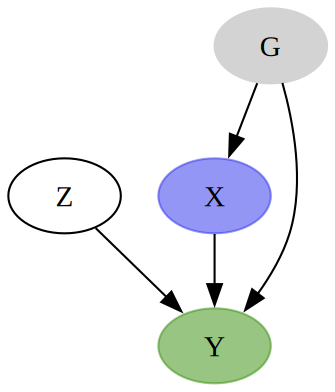

In [41]:
import graphviz as gr

g = gr.Digraph(graph_attr={"dpi": "150"})
g.node(name="Z", label="Z")
g.node(name="G", label="G", color="lightgray", style="filled")
g.node(name="X", label="X", color="#2a2eec80", style="filled")
g.node(name="Y", label="Y", color="#328c0680", style="filled")
g.edge(tail_name="X", head_name="Y")
g.edge(tail_name="Z", head_name="Y")
g.edge(tail_name="G", head_name="X")
g.edge(tail_name="G", head_name="Y")
g

We are interested in the relationship between $X$ and $Y$. 

## Prepare Notebook

In [2]:
from typing import Any

import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from pymc import do

az.style.use("arviz-variat")
plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
seed: int = 42
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Generate Data

Here we define the generative model in PyMC following the causal graph above.

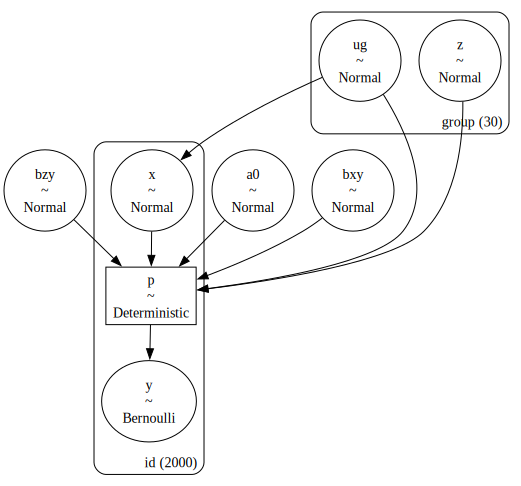

In [4]:
n_groups: int = 30
n_id: int = 2_000
g = rng.choice(n_groups, size=(n_id,), replace=True)

coords: dict[str, Any] = {
    "group": np.arange(n_groups),
    "id": np.arange(n_id),
}

with pm.Model(coords=coords) as generative_model:
    a0 = pm.Normal("a0", mu=0, sigma=1)
    bzy = pm.Normal("bzy", mu=0, sigma=1)
    bxy = pm.Normal("bxy", mu=0, sigma=1)
    ug = pm.Normal("ug", mu=0, sigma=1.5, dims="group")
    x = pm.Normal("x", mu=ug[g], sigma=1, dims="id")
    z = pm.Normal("z", mu=0, sigma=1, dims="group")
    p = pm.Deterministic(
        "p", pm.math.invlogit(a0 + bxy * x + ug[g] + bzy * z[g]), dims="id"
    )
    pm.Bernoulli("y", p, dims="id")


pm.model_to_graphviz(generative_model)

We can now set specific values for the parameters and generate a sample that we will use as *observed* data.

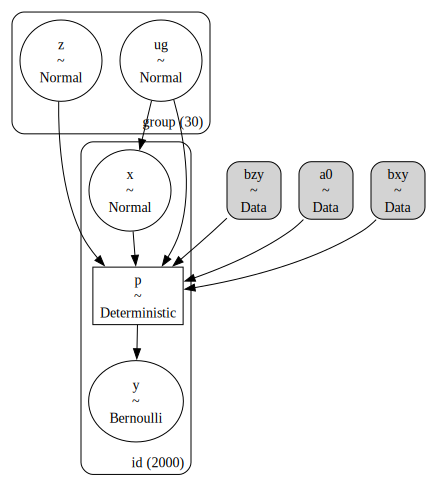

In [5]:
true_params = {"a0": -2, "bzy": 1.0, "bxy": 0.0}

generative_model_do = do(generative_model, true_params)

pm.model_to_graphviz(generative_model_do)

In [6]:
with generative_model_do:
    idata_obs = pm.sample_prior_predictive(draws=1, random_seed=rng)

Sampling: [ug, x, y, z]


In [7]:
ug_obs = idata_obs["prior"]["ug"].sel(chain=0, draw=0).to_numpy()
z_obs = idata_obs["prior"]["z"].sel(chain=0, draw=0).to_numpy()
x_obs = idata_obs["prior"]["x"].sel(chain=0, draw=0).to_numpy()
y_obs = idata_obs["prior"]["y"].sel(chain=0, draw=0).to_numpy()

assert ug_obs.shape == (n_groups,)
assert z_obs.shape == (n_groups,)
assert x_obs.shape == (n_id,)
assert y_obs.shape == (n_id,)

data_df = pd.DataFrame(
    {"group": g, "x": x_obs, "y": y_obs, "z": z_obs[g], "ug": ug_obs[g]}
)

data_df.head()

,group,x,y,z,ug
0,2,-1.636772,0,-0.784611,-0.262631
1,23,-0.630586,0,0.432475,-0.856320
2,19,0.632257,1,-0.802185,-0.376058
3,13,-4.794478,0,0.472600,-3.984009
4,12,1.006184,0,0.196072,0.005123


## Exploratory Data Analysis

Let's look into the data and reproduce the plots from the video. First, we look at the group counts.

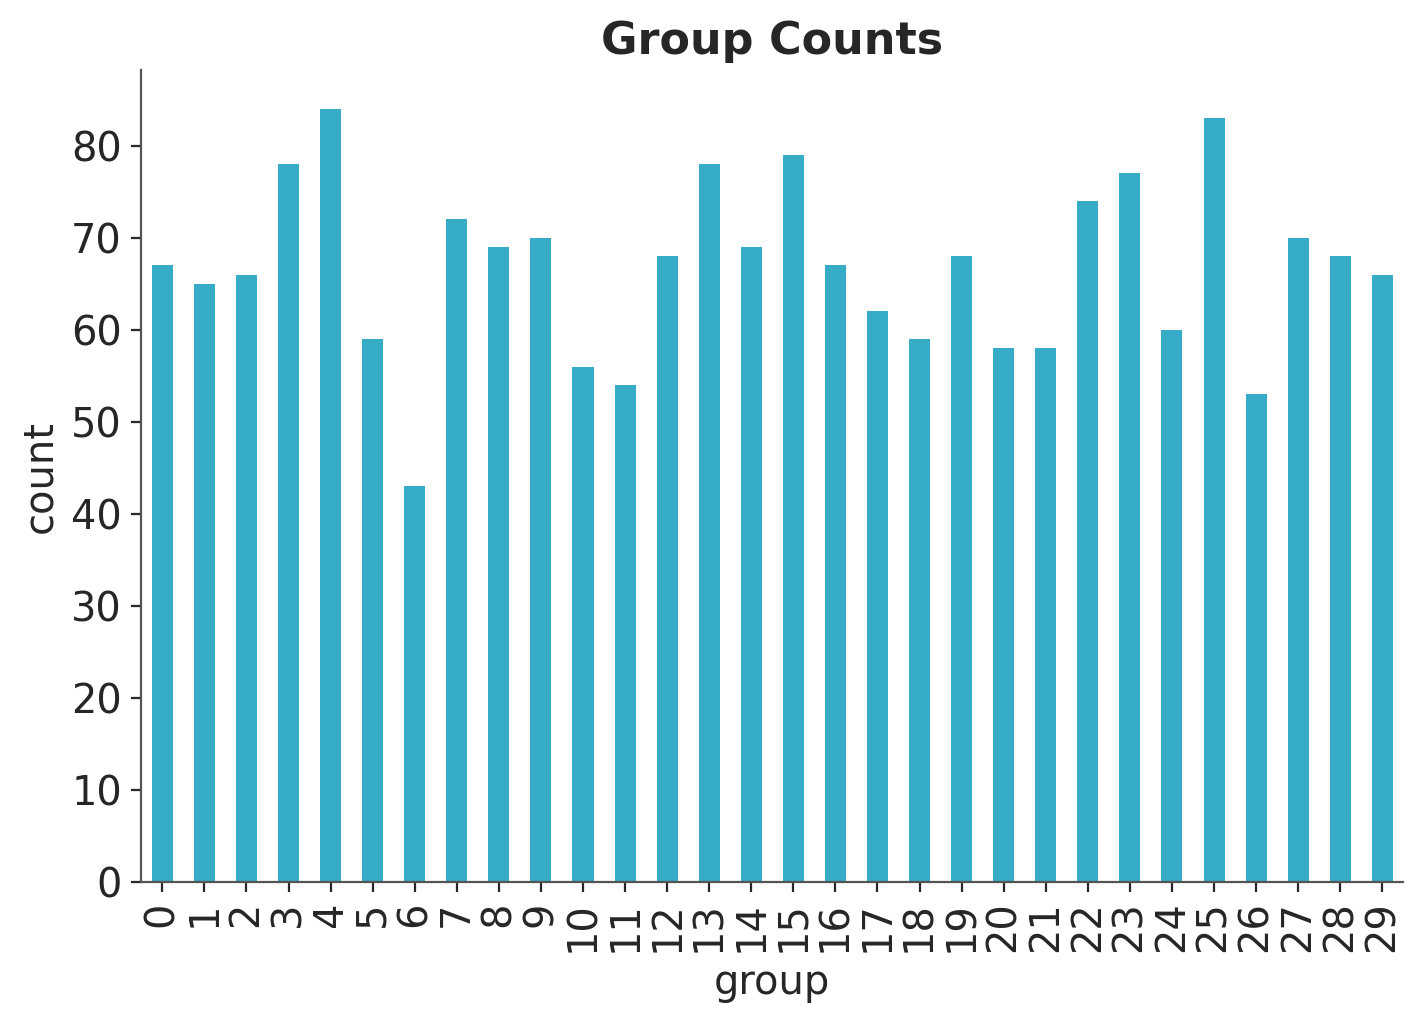

In [8]:
fig, ax = plt.subplots()

data_df.value_counts("group").sort_index().plot.bar(ax=ax)
ax.set(xlabel="group", ylabel="count", title="Group Counts");

We see that each group has a different number of observations.

Next we plot the relationship between the group and the variable of interest $x$.


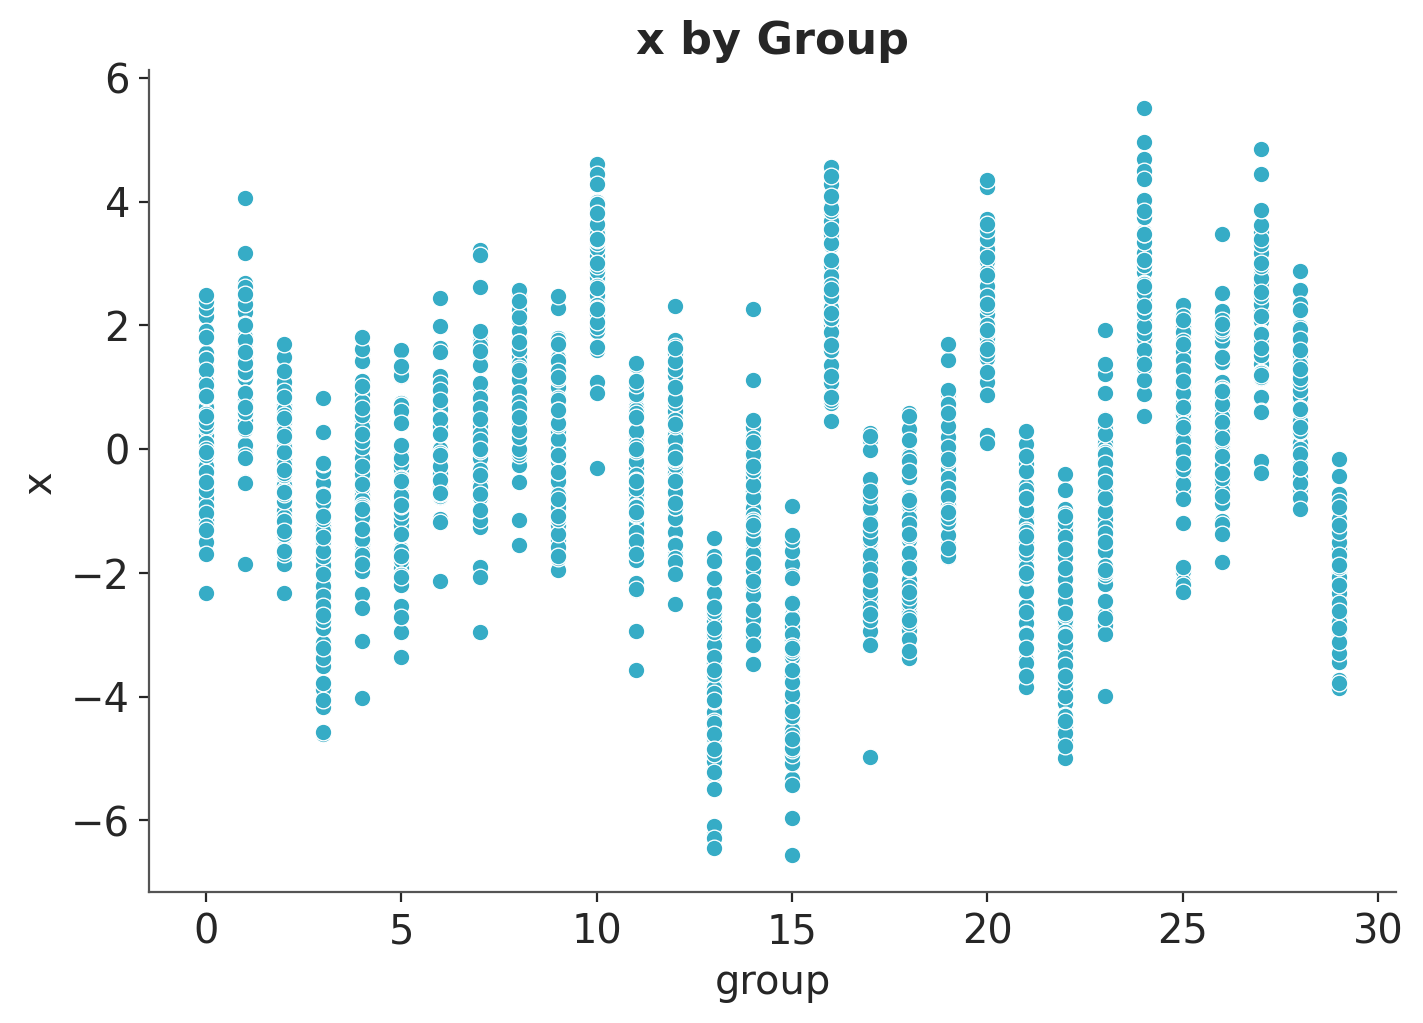

In [9]:
fig, ax = plt.subplots()
sns.scatterplot(data=data_df, x="group", y="x", ax=ax)
ax.set(xlabel="group", ylabel="x", title="x by Group");

We clearly see that the mean of $x$ is different for each group.

Now we plot the relationship between $x$ and $y$.

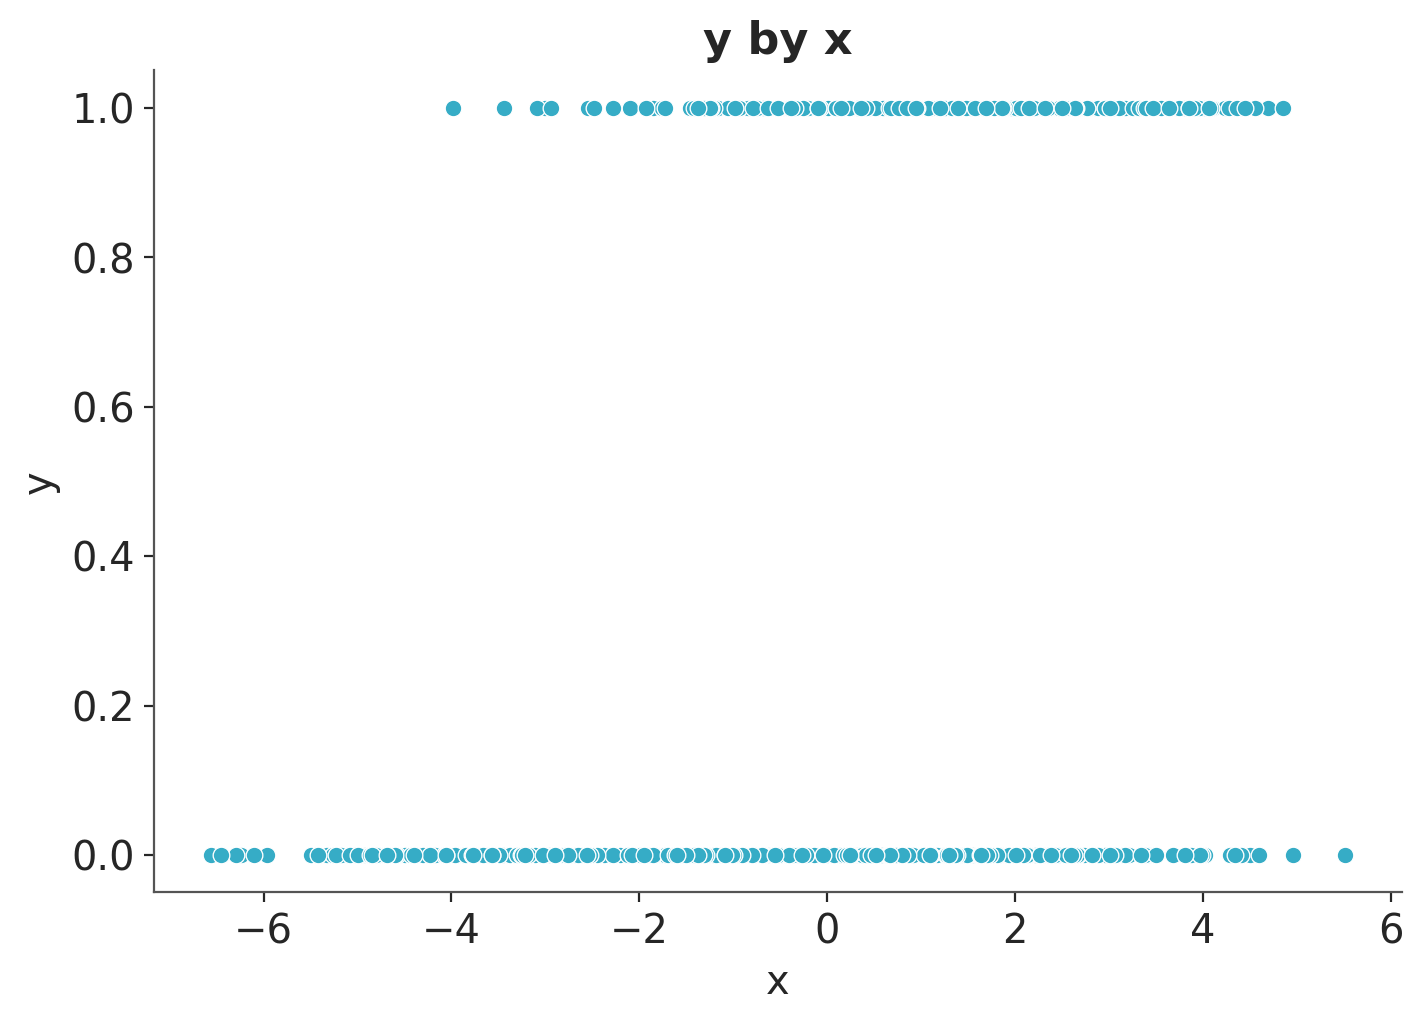

In [10]:
fig, ax = plt.subplots()
sns.scatterplot(data=data_df, x="x", y="y", ax=ax)
ax.set(xlabel="x", ylabel="y", title="y by x");

It seems that there is a relationship between $x$ and $y$ (the higher $x$ the higher $y$). However, as the true value of $b_{xy}$ is $0$, we know this is just due to the group-level confounding.

Now we are ready to fit all the models from the video.

## Naive Model

First we fit the naive model where we simply ignore the group-level confounding.

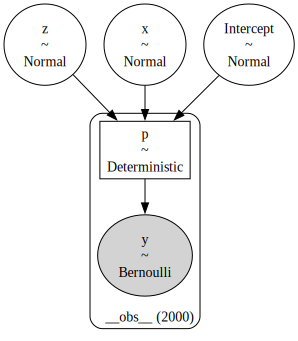

In [11]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=1),
    "x": bmb.Prior("Normal", mu=0, sigma=1),
    "z": bmb.Prior("Normal", mu=0, sigma=1),
}


df = pd.DataFrame(
    {
        "x": x_obs,
        "y": y_obs,
        "z": z_obs[g],  # map group-level z to observation level
        "group": g,  #  group indicator per observation
    }
)

naive_model = bmb.Model(
    "y ~ x + z",
    data=df,
    family="bernoulli",
    priors=priors,
    auto_scale=False,
)

naive_model.build()
naive_model.graph()

In [12]:
fit_params = {
    "draws": 1_000,
    "chains": 4,
    "target_accept": 0.9,
    "random_seed": rng,
}


idata_naive = naive_model.fit(**fit_params)

Modeling the probability that y==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, x, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Let's look at the posterior distributions of the parameters.

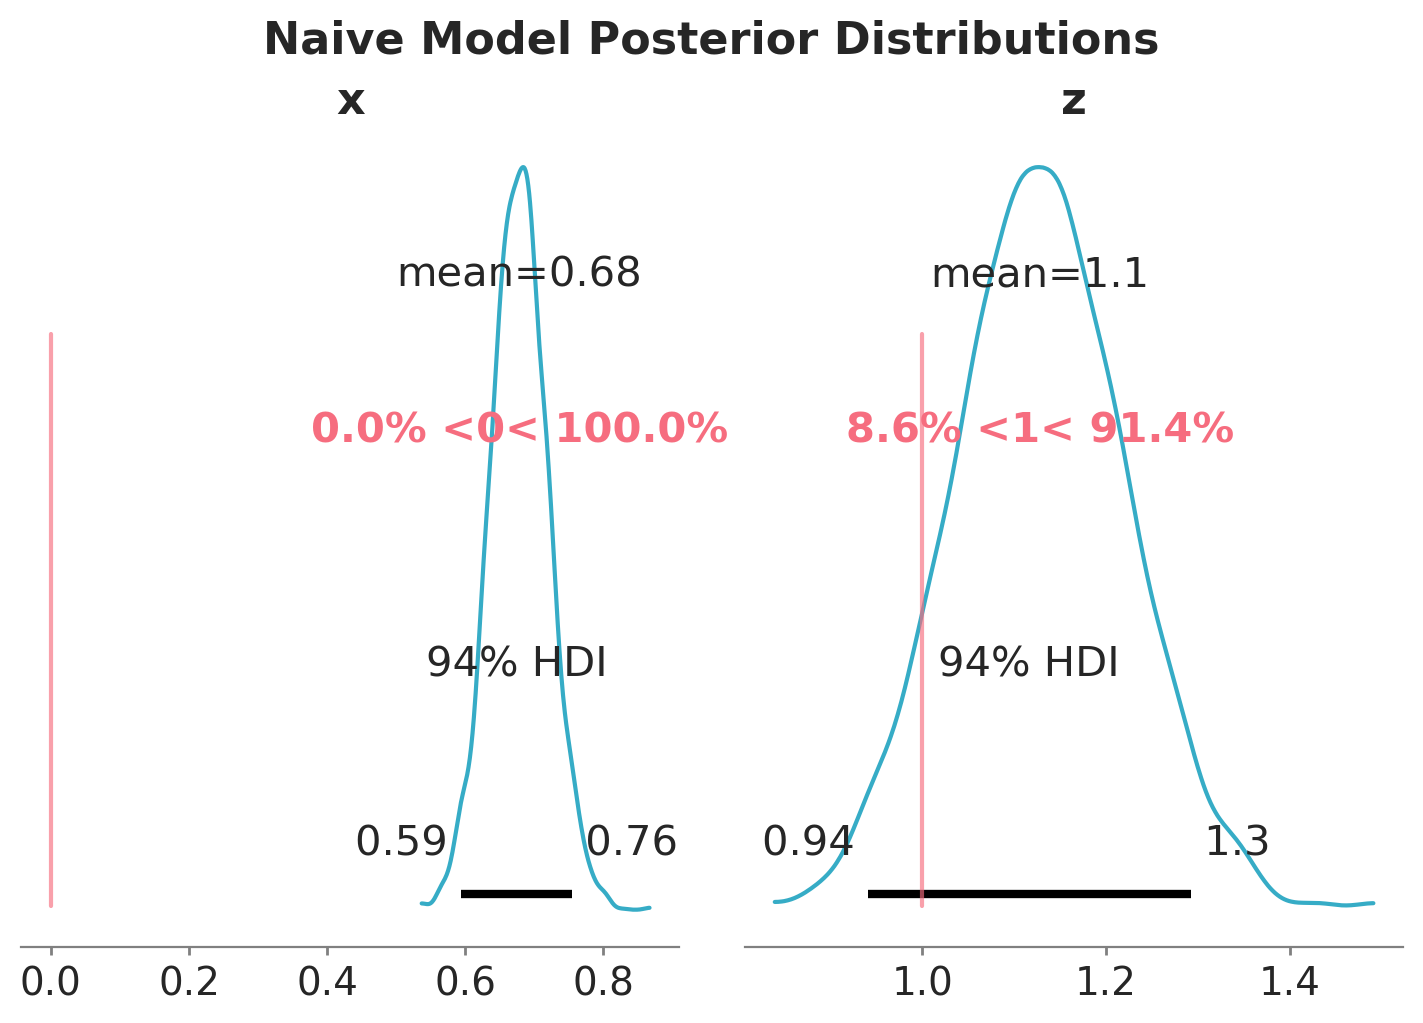

In [13]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(7, 5),
    sharex=False,
    sharey=False,
    layout="constrained",
)

az.plot_posterior(
    idata_naive,
    var_names=["x", "z"],
    ref_val={
        "x": [{"ref_val": true_params["bxy"]}],
        "z": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax,
)
fig.suptitle("Naive Model Posterior Distributions", fontsize=16);

As expected, the posterior distribution of $b_{xy}$ does not include the true value of $0$. The other parameter, $b_{zy}$, is estimated with a high uncertainty.

## Fixed Effects Model

Now we fit the fixed effects model where we control for the group-level confounding by including the group-level intercepts as parameters (no hierarchical structure).

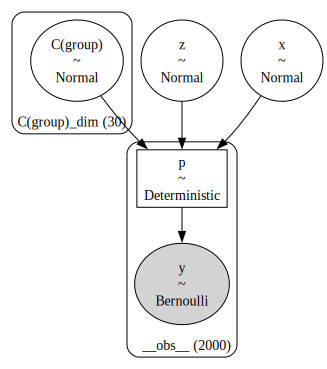

In [14]:
priors = {
    "C(group)": bmb.Prior("Normal", mu=0, sigma=10),
    "x": bmb.Prior("Normal", mu=0, sigma=1),
    "z": bmb.Prior("Normal", mu=0, sigma=1),
}

fixed_effects_model = bmb.Model(
    "y ~ 0 + C(group) + x + z",
    data=df,
    family="bernoulli",
    priors=priors,
)

fixed_effects_model.build()
fixed_effects_model.graph()

In [15]:
idata_fixed_effects = fixed_effects_model.fit(**fit_params)

Modeling the probability that y==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [C(group), x, z]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Let's look at the posterior distributions of the parameters of the fixed effects model.

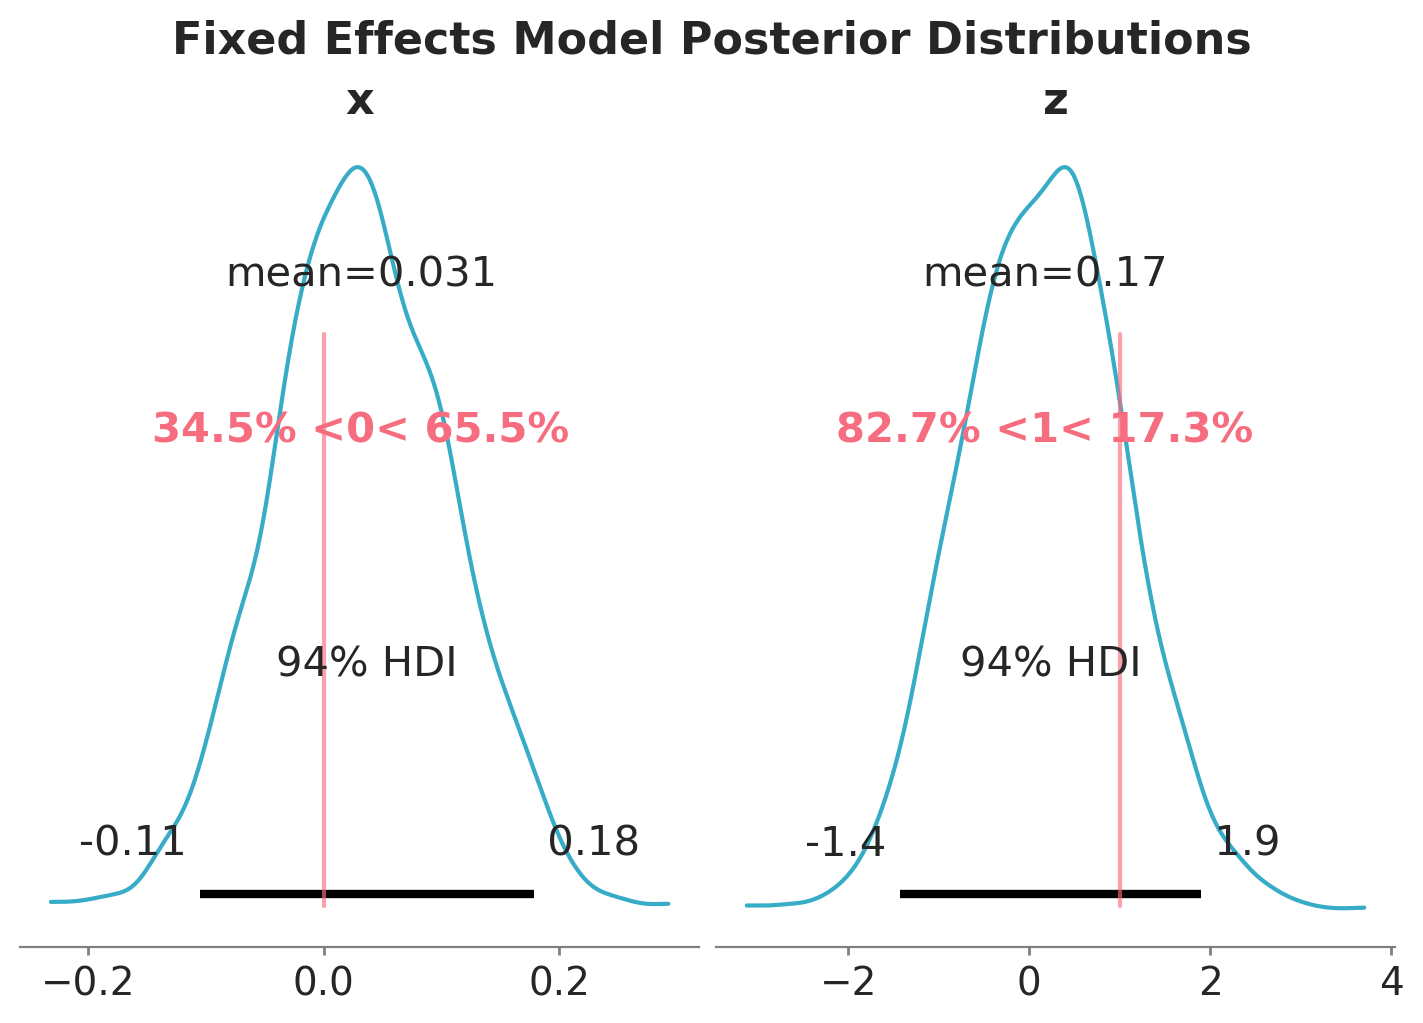

In [16]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(7, 5),
    sharex=False,
    sharey=False,
    layout="constrained",
)

az.plot_posterior(
    idata_fixed_effects,
    var_names=["x", "z"],
    ref_val={
        "x": [{"ref_val": true_params["bxy"]}],
        "z": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax,
)
fig.suptitle("Fixed Effects Model Posterior Distributions", fontsize=16);

This model is able to estimate the true value of $b_{xy}$ and $b_{zy}$. We can compare the naive and fixed effects models parameter estimates: 

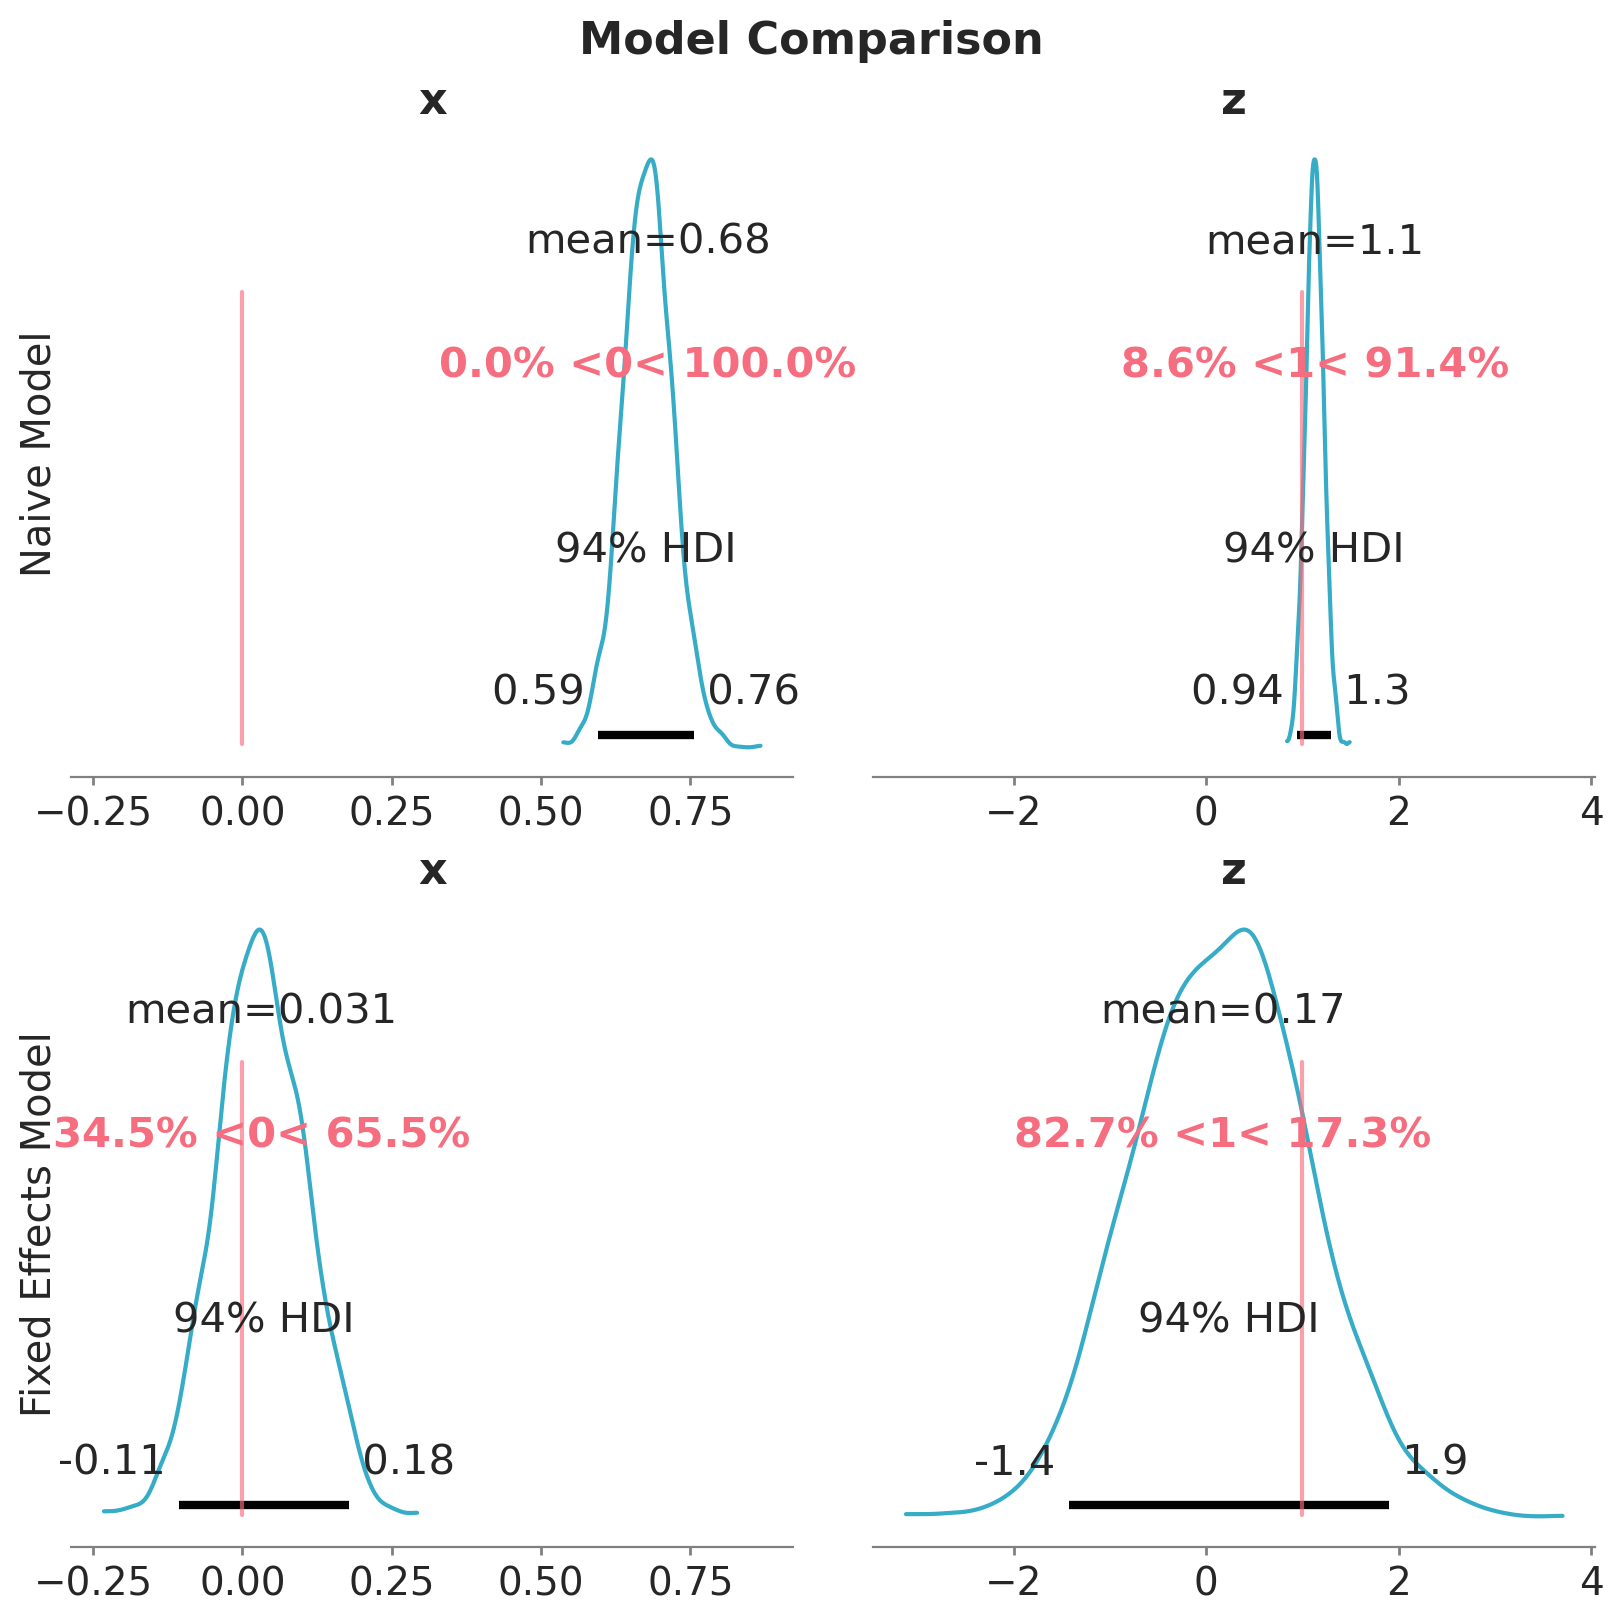

In [17]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(8, 8),
    sharex="col",
    sharey=False,
    layout="constrained",
)

az.plot_posterior(
    idata_naive,
    var_names=["x", "z"],
    ref_val={
        "x": [{"ref_val": true_params["bxy"]}],
        "z": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax[0],
)

az.plot_posterior(
    idata_fixed_effects,
    var_names=["x", "z"],
    ref_val={
        "x": [{"ref_val": true_params["bxy"]}],
        "z": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax[1],
)

ax[0, 0].set(ylabel="Naive Model")
ax[1, 0].set(ylabel="Fixed Effects Model")

fig.suptitle("Model Comparison", fontsize=16);

Observe that the uncertainty of $b_{zy}$ is higher in the fixed effects model. The reason is because the intercepts and the group-level $z$ terms are not identifiable (there are many ways to sum up two numbers to get the same group-level intercept).

## Multilevel Model

Now we fit a multilevel model where we control for the group-level confounding by including the group-level intercepts as parameters and a hierarchical structure. We use a non-centered parameterization to improve the sampling efficiency.

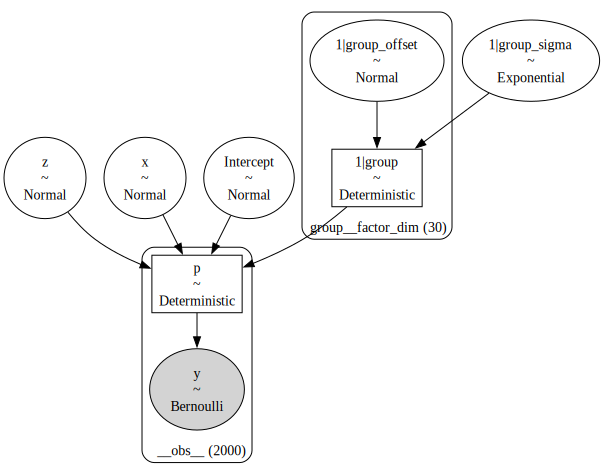

In [18]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=1),
    "x": bmb.Prior("Normal", mu=0, sigma=1),
    "z": bmb.Prior("Normal", mu=0, sigma=1),
    "1|group": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
}

multilevel_model = bmb.Model(
    "y ~ x + z + (1|group)",
    data=df,
    family="bernoulli",
    priors=priors,
)

multilevel_model.build()
multilevel_model.graph()


In [19]:
idata_multilevel = multilevel_model.fit(**fit_params)

Modeling the probability that y==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, x, z, 1|group_sigma, 1|group_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


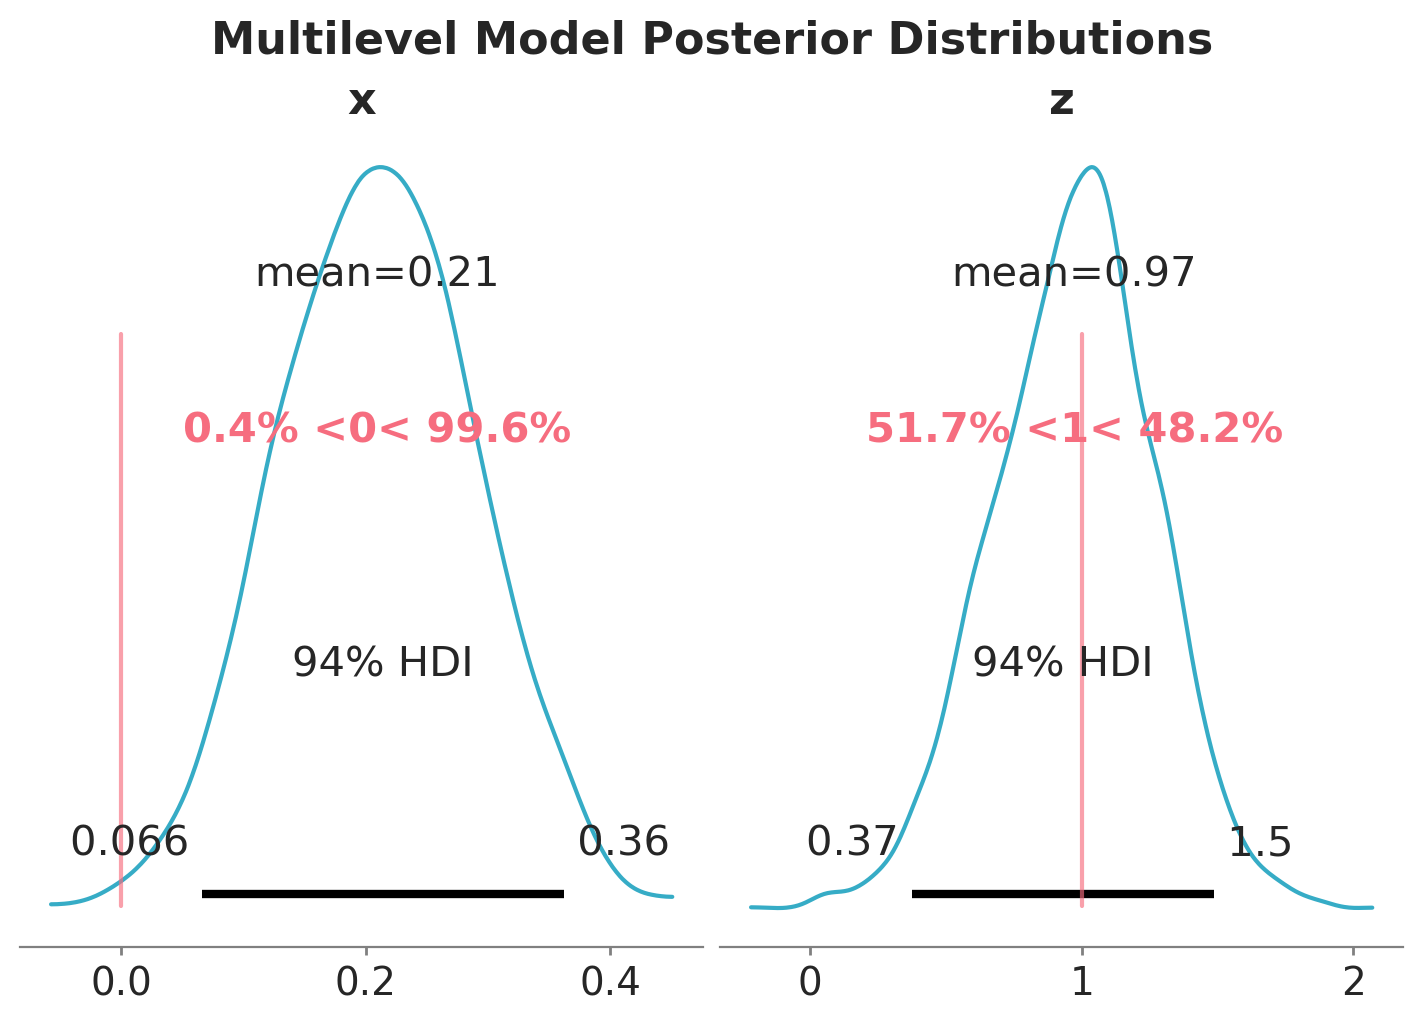

In [20]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(7, 5),
    sharex=False,
    sharey=False,
    layout="constrained",
)

az.plot_posterior(
    idata_multilevel,
    var_names=["x", "z"],
    ref_val={
        "x": [{"ref_val": true_params["bxy"]}],
        "z": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax,
)
fig.suptitle("Multilevel Model Posterior Distributions", fontsize=16);

In this case, the multilevel model is not able to estimate the true value of $b_{xy}$. The reason is that it is not really factoring out the group-level confounding through the mean. Still, for this model, $b_{zy}$ is correctly estimated with narrower uncertainty as compared to the fixed effects model:

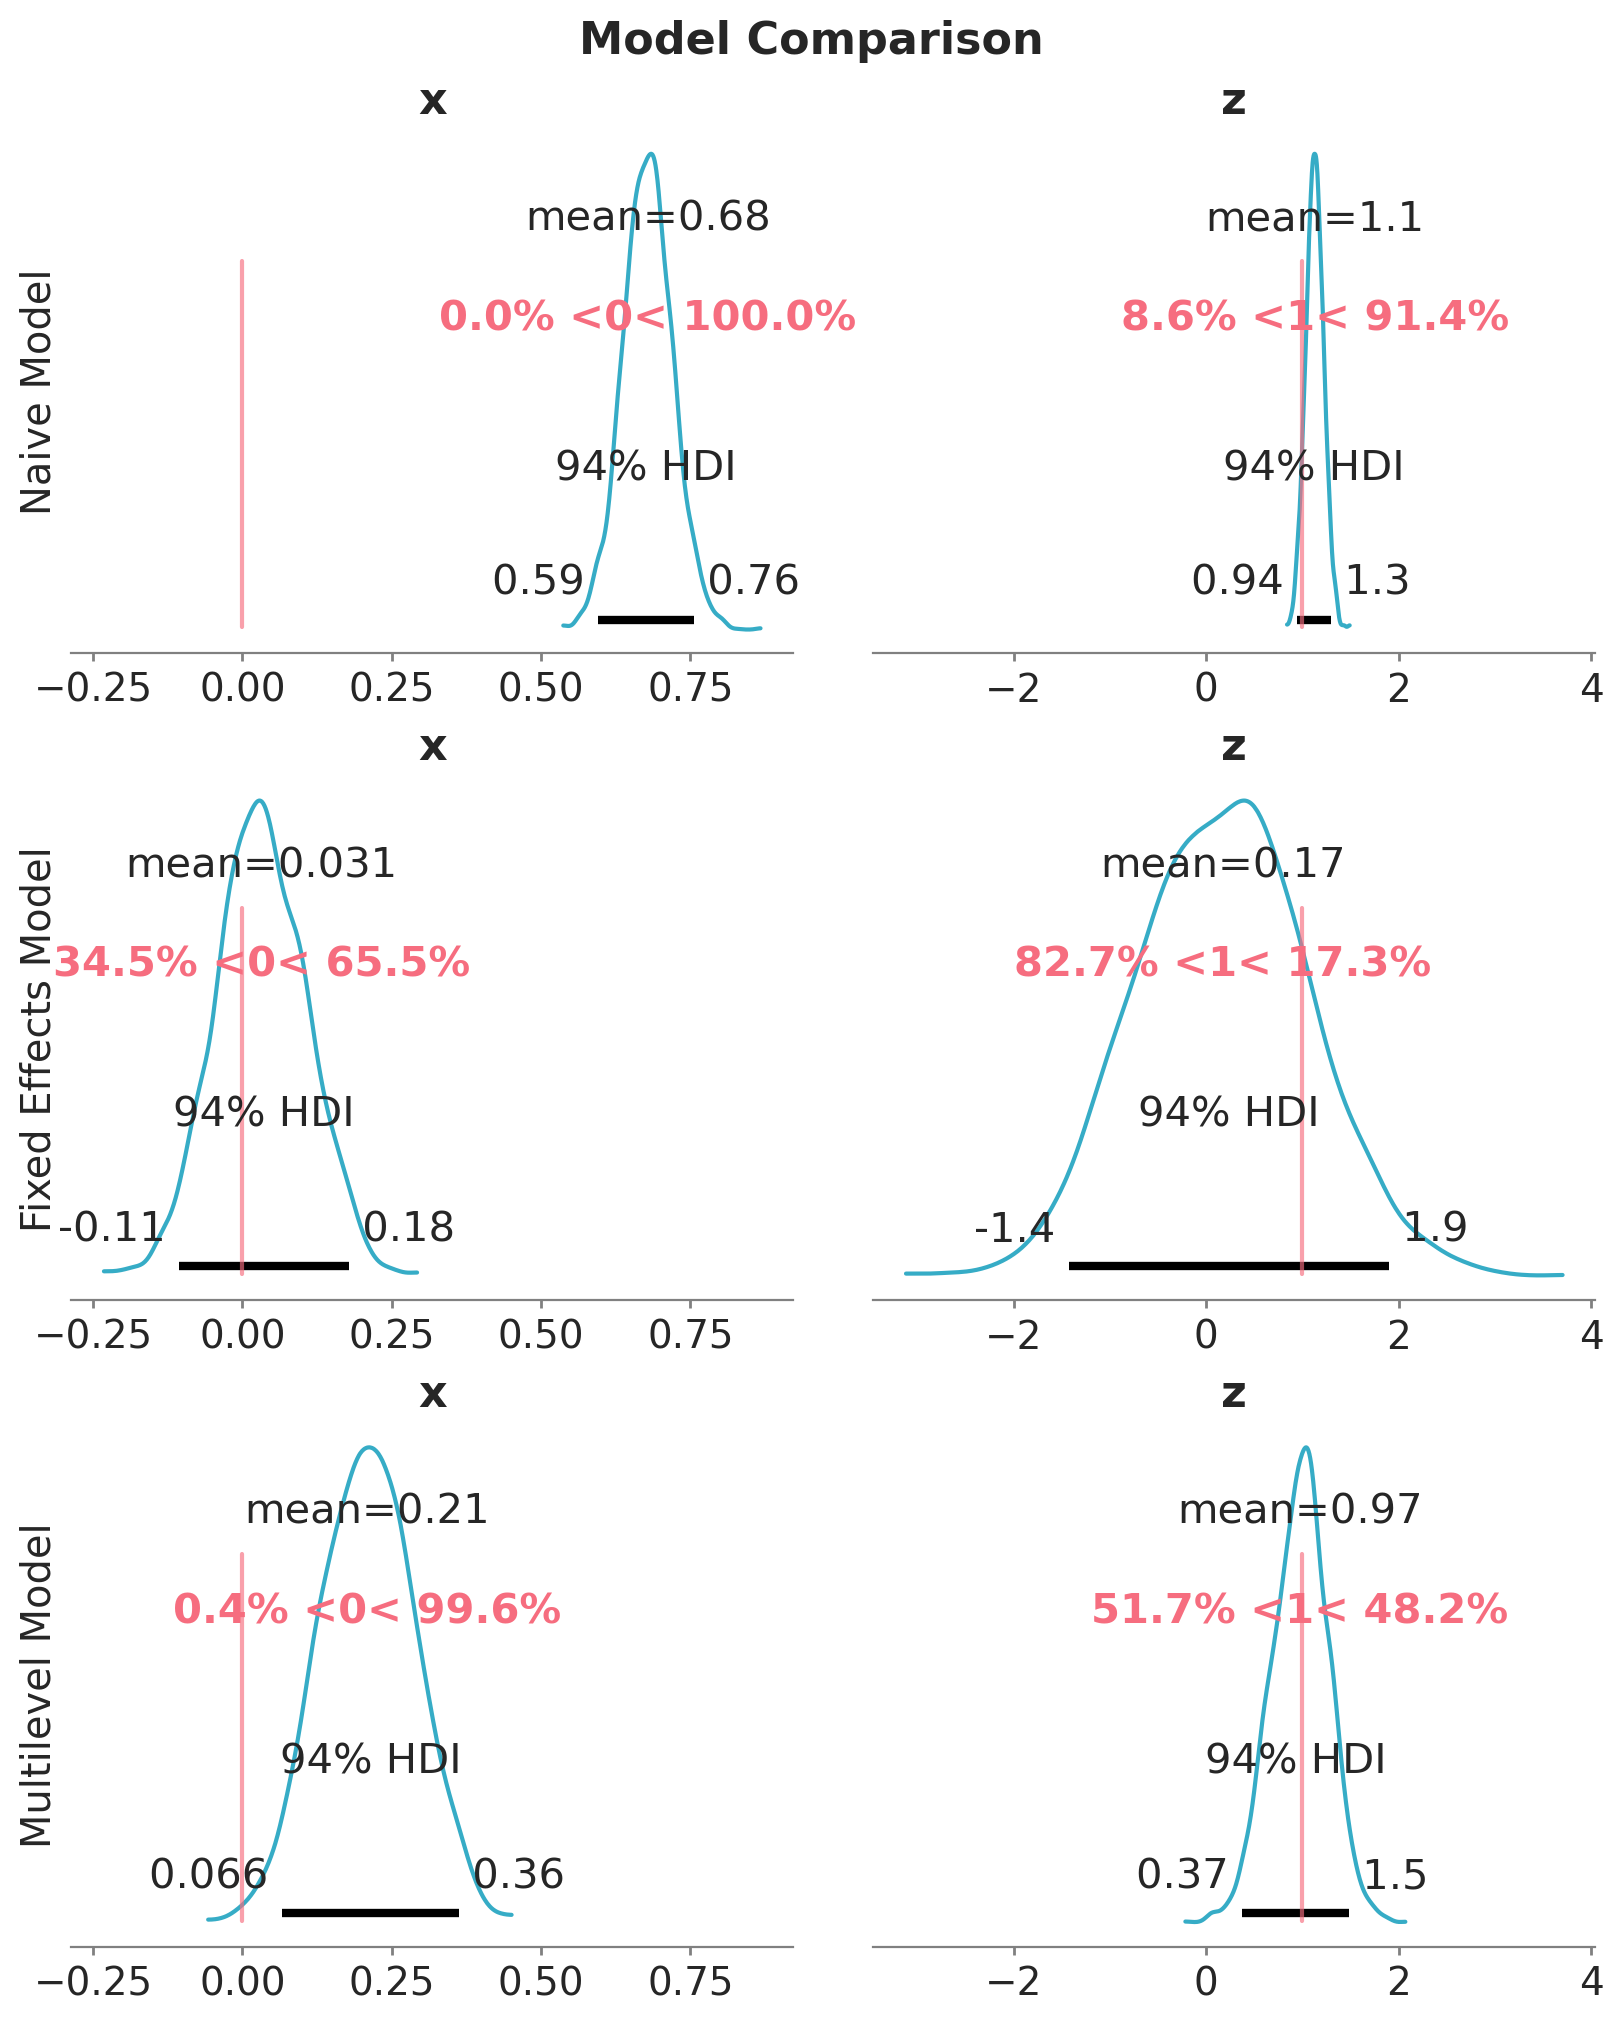

In [21]:
fig, ax = plt.subplots(
    nrows=3,
    ncols=2,
    figsize=(8, 10),
    sharex="col",
    sharey=False,
    layout="constrained",
)

az.plot_posterior(
    idata_naive,
    var_names=["x", "z"],
    ref_val={
        "x": [{"ref_val": true_params["bxy"]}],
        "z": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax[0],
)

az.plot_posterior(
    idata_fixed_effects,
    var_names=["x", "z"],
    ref_val={
        "x": [{"ref_val": true_params["bxy"]}],
        "z": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax[1],
)

az.plot_posterior(
    idata_multilevel,
    var_names=["x", "z"],
    ref_val={
        "x": [{"ref_val": true_params["bxy"]}],
        "z": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax[2],
)

ax[0, 0].set(ylabel="Naive Model")
ax[1, 0].set(ylabel="Fixed Effects Model")
ax[2, 0].set(ylabel="Multilevel Model")

fig.suptitle("Model Comparison", fontsize=16);

## Mundlak Model

This is a cool trick! The idea is to explicitly add the group-level mean of $x$ as a predictor as a proxy for the unmeasured group-level confounder. We keep the (non-centered) multilevel model structure.

In [22]:
df["xbar"] = data_df.groupby("group")["x"].mean().to_numpy()[g]

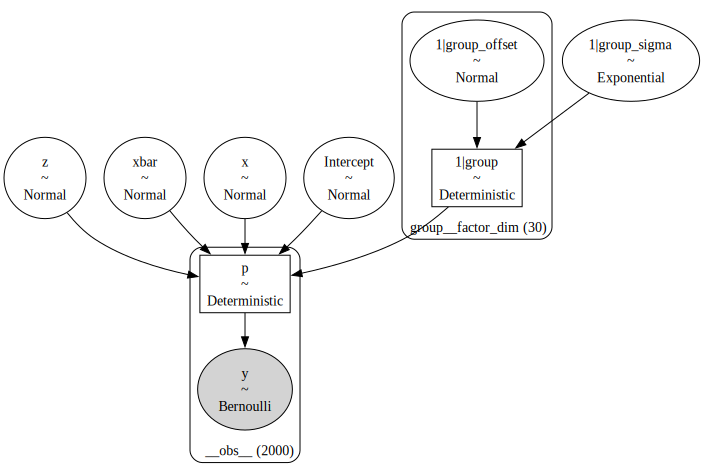

In [23]:
priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=1),
    "x": bmb.Prior("Normal", mu=0, sigma=1),
    "z": bmb.Prior("Normal", mu=0, sigma=1),
    "xbar": bmb.Prior("Normal", mu=0, sigma=1),
    "1|group": bmb.Prior("Normal", mu=0, sigma=bmb.Prior("Exponential", lam=1)),
}

mundlak_model = bmb.Model(
    "y ~ x + z + xbar + (1|group)",
    data=df,
    family="bernoulli",
    priors=priors,
)

mundlak_model.build()
mundlak_model.graph()


In [24]:
idata_mundlak = mundlak_model.fit(**fit_params)

Modeling the probability that y==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, x, z, xbar, 1|group_sigma, 1|group_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


This model is able to estimate the true value of $b_{xy}$ and $b_{zy}$ with narrower uncertainty for $b_{zy}$ as compared to the fixed effects model.

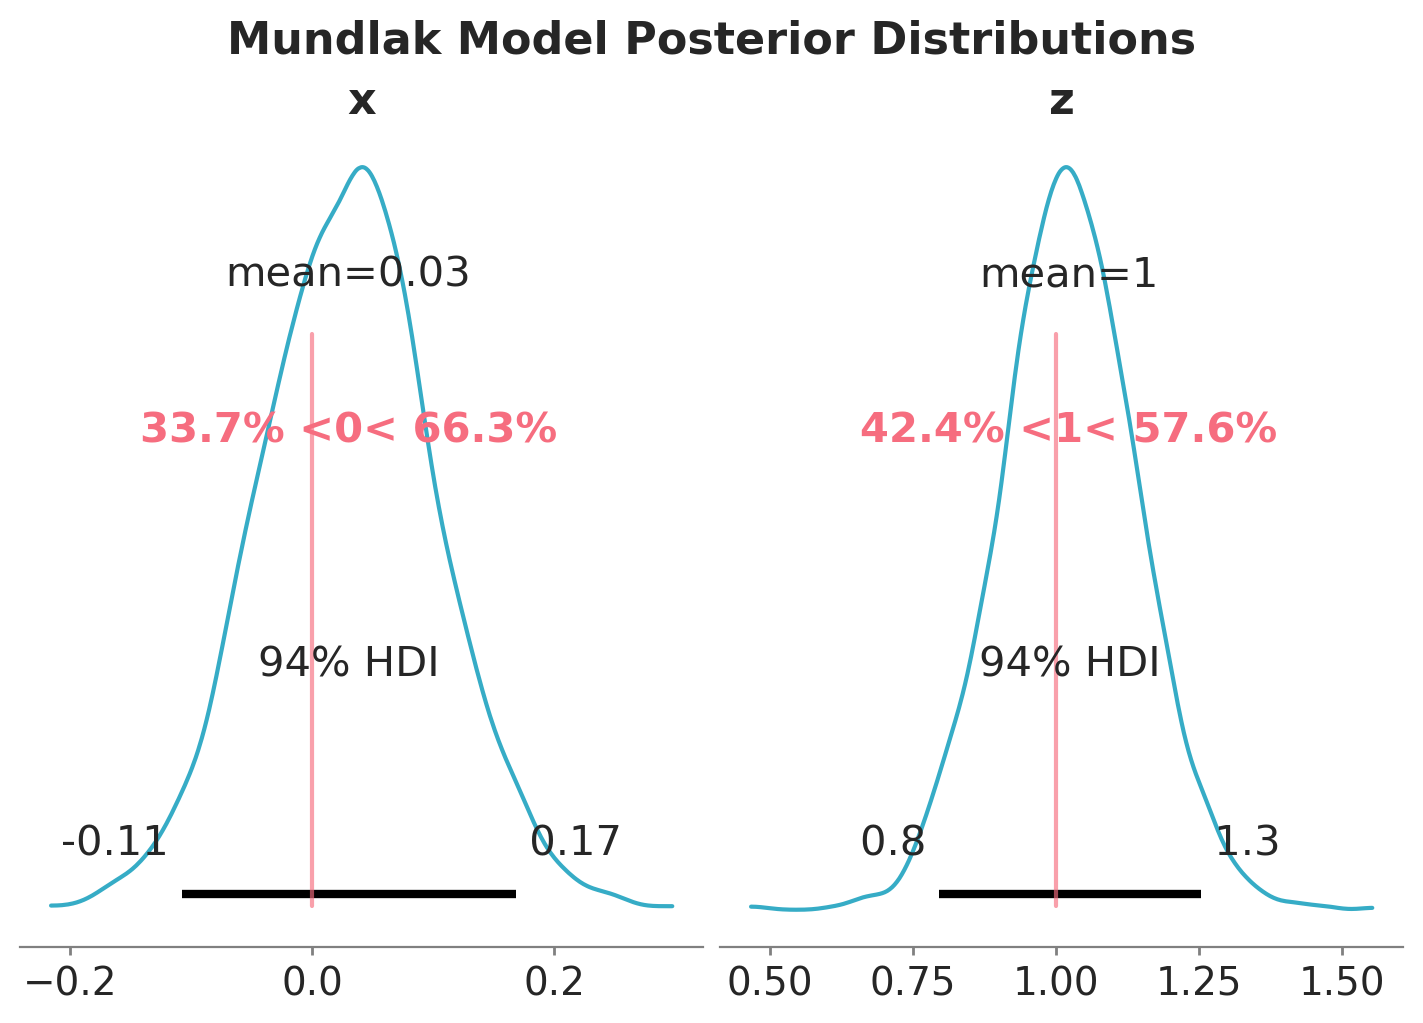

In [25]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(7, 5),
    sharex=False,
    sharey=False,
    layout="constrained",
)

az.plot_posterior(
    idata_mundlak,
    var_names=["x", "z"],
    ref_val={
        "x": [{"ref_val": true_params["bxy"]}],
        "z": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax,
)
fig.suptitle("Mundlak Model Posterior Distributions", fontsize=16);

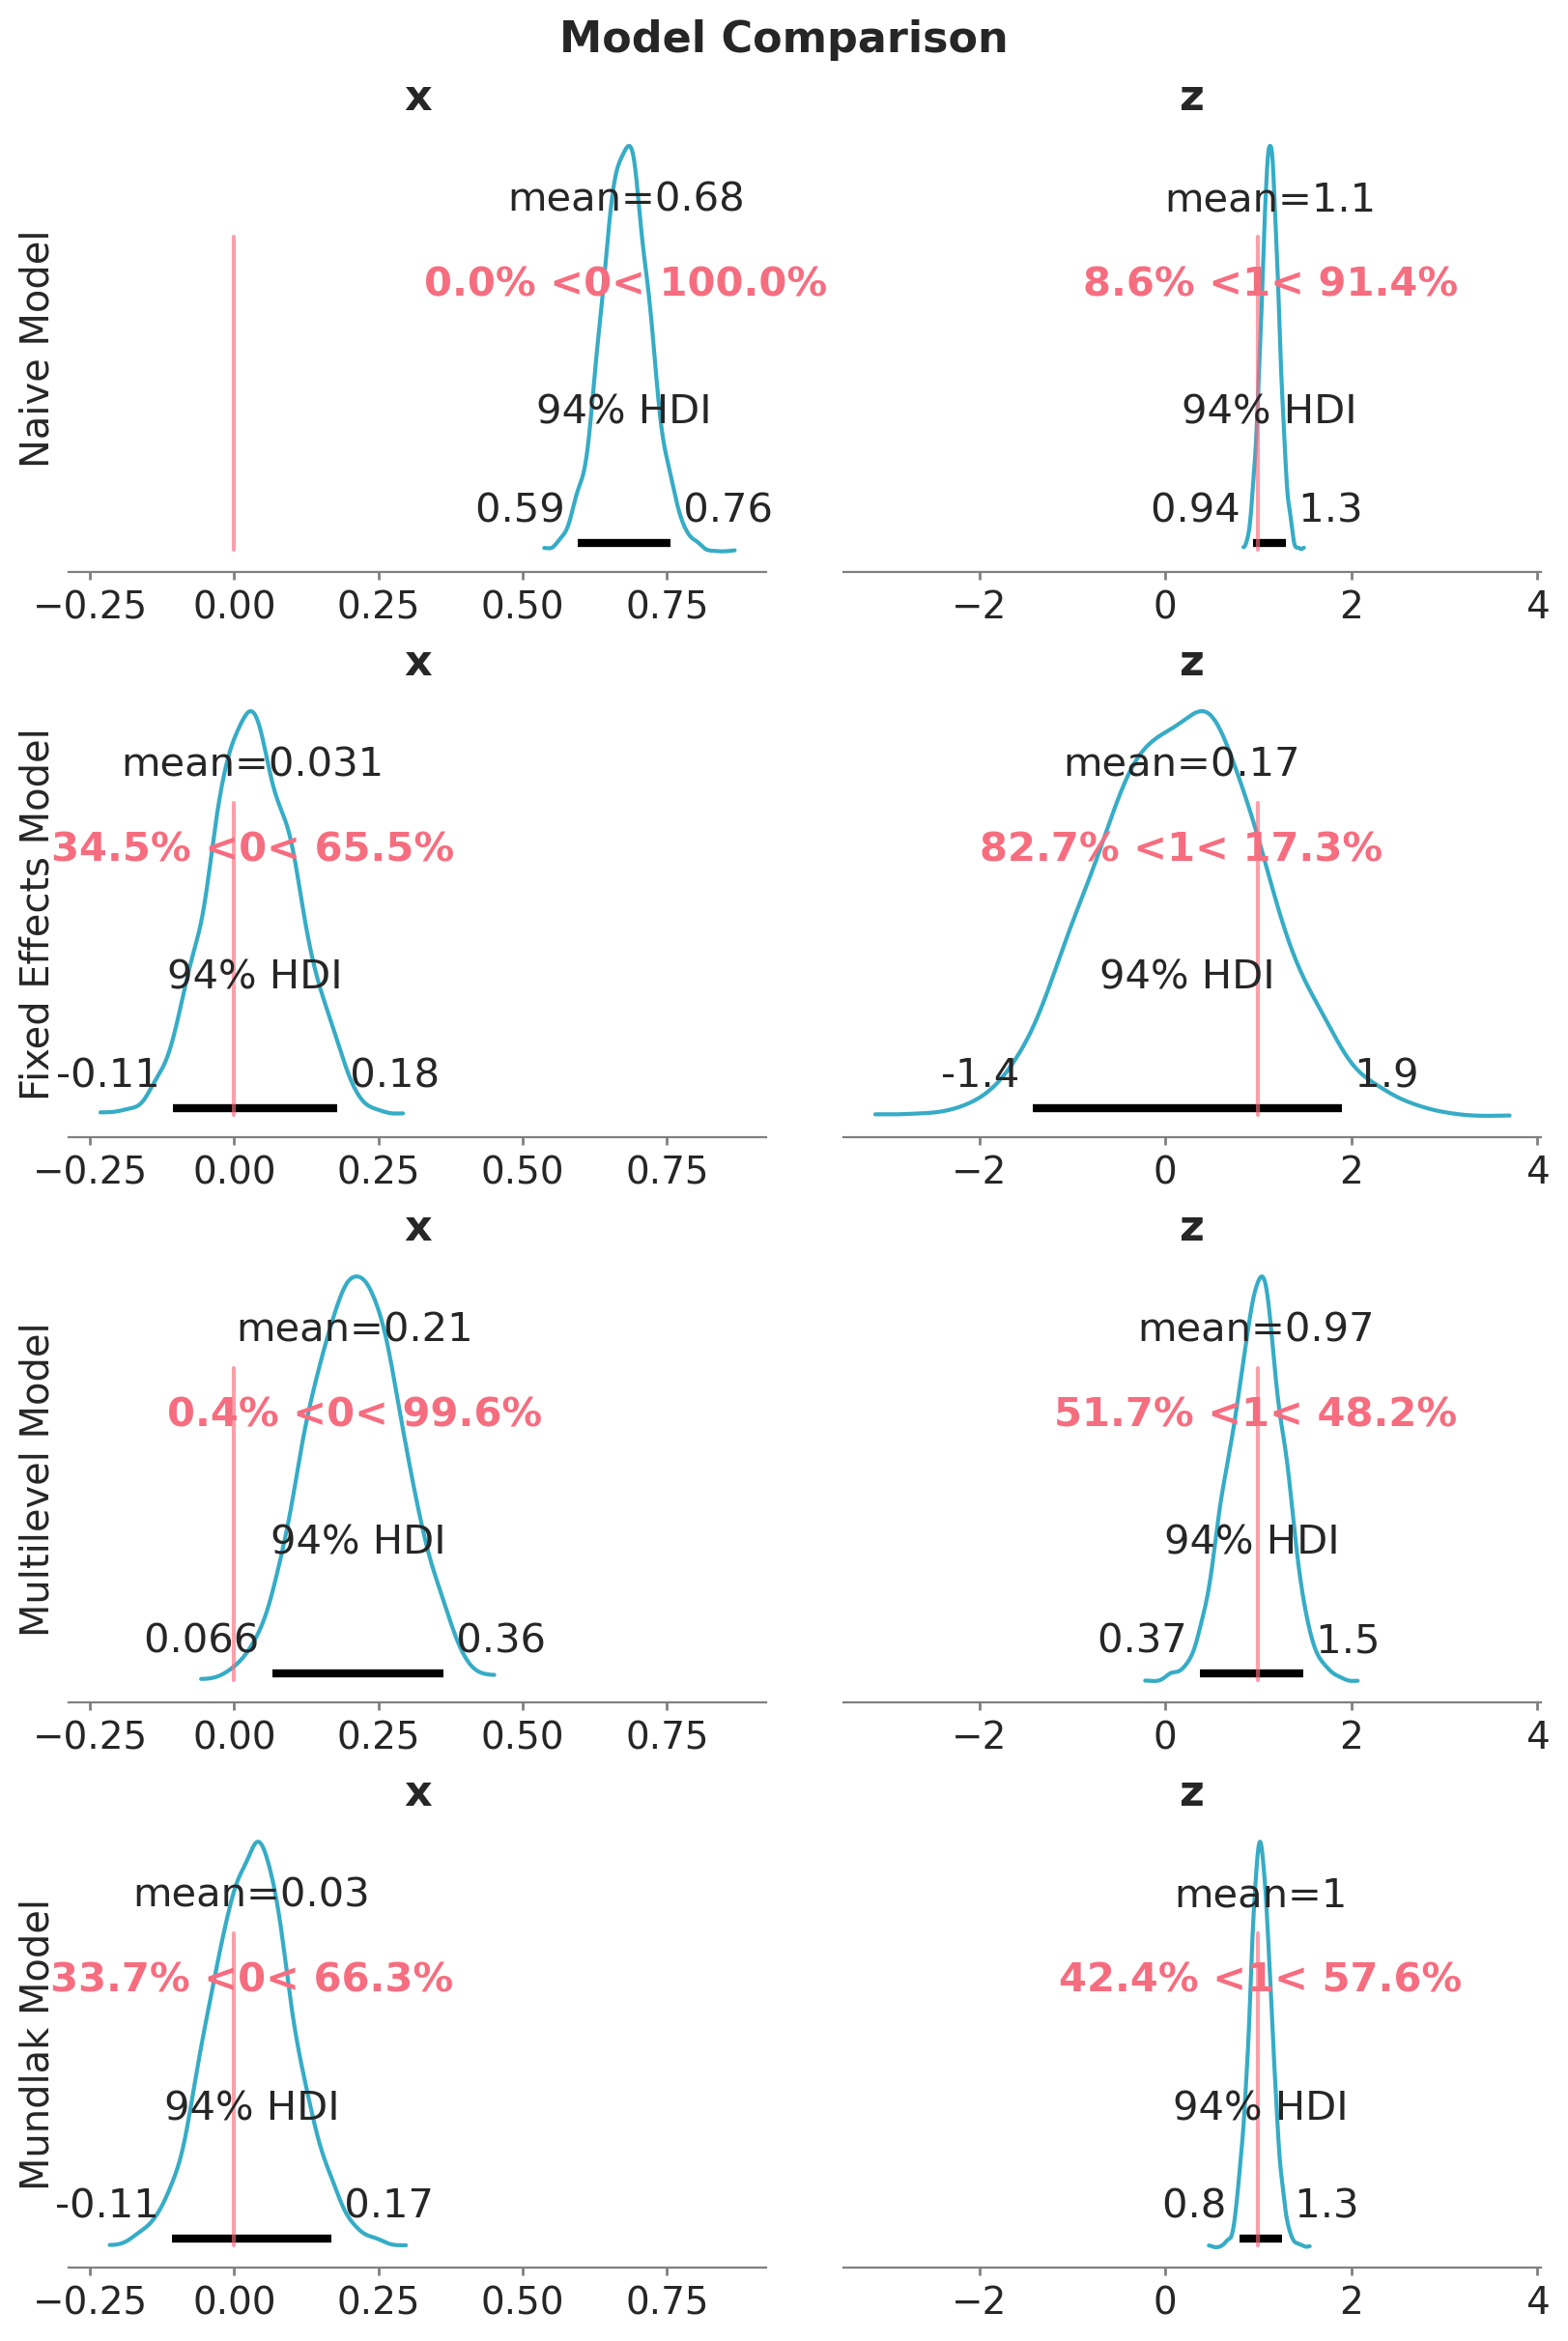

In [26]:
fig, ax = plt.subplots(
    nrows=4,
    ncols=2,
    figsize=(8, 12),
    sharex="col",
    sharey=False,
    layout="constrained",
)

az.plot_posterior(
    idata_naive,
    var_names=["x", "z"],
    ref_val={
        "x": [{"ref_val": true_params["bxy"]}],
        "z": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax[0],
)

az.plot_posterior(
    idata_fixed_effects,
    var_names=["x", "z"],
    ref_val={
        "x": [{"ref_val": true_params["bxy"]}],
        "z": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax[1],
)

az.plot_posterior(
    idata_multilevel,
    var_names=["x", "z"],
    ref_val={
        "x": [{"ref_val": true_params["bxy"]}],
        "z": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax[2],
)

az.plot_posterior(
    idata_mundlak,
    var_names=["x", "z"],
    ref_val={
        "x": [{"ref_val": true_params["bxy"]}],
        "z": [{"ref_val": true_params["bzy"]}],
    },
    ax=ax[3],
)

ax[0, 0].set(ylabel="Naive Model")
ax[1, 0].set(ylabel="Fixed Effects Model")
ax[2, 0].set(ylabel="Multilevel Model")
ax[3, 0].set(ylabel="Mundlak Model")
fig.suptitle("Model Comparison", fontsize=16);

## Model Comparison

We can also have a more compact visualization of the parameter estimates:

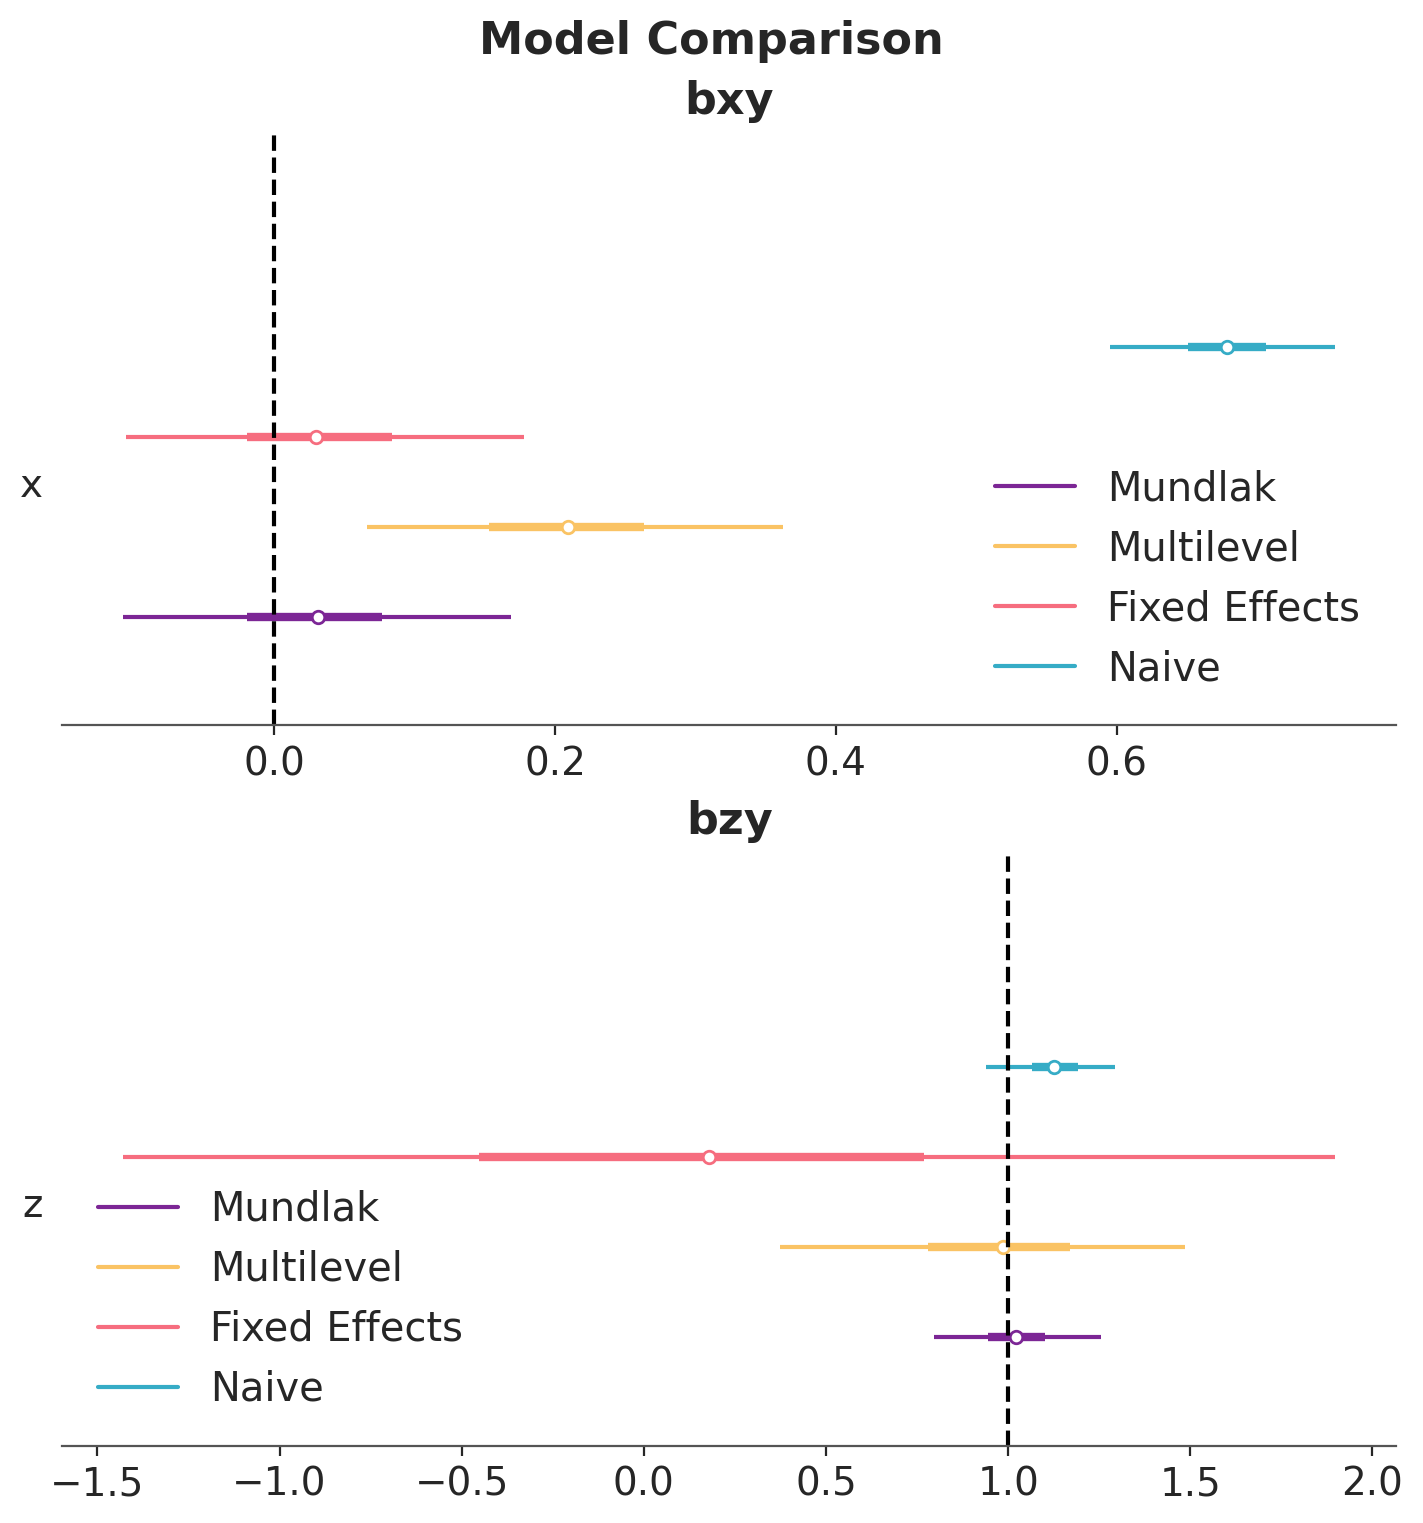

In [27]:
fig, ax = plt.subplots(figsize=(7, 7.5), nrows=2, ncols=1)

az.plot_forest(
    data=[
        idata_naive,
        idata_fixed_effects,
        idata_multilevel,
        idata_mundlak,
    ],
    model_names=[
        "Naive",
        "Fixed Effects",
        "Multilevel",
        "Mundlak",
    ],
    var_names=["x"],
    combined=True,
    ax=ax[0],
)

ax[0].axvline(x=true_params["bxy"], color="k", linestyle="--")

ax[0].get_legend().set_loc("lower right")
ax[0].set_title("bxy", fontsize=16)

az.plot_forest(
    data=[
        idata_naive,
        idata_fixed_effects,
        idata_multilevel,
        idata_mundlak,
    ],
    model_names=[
        "Naive",
        "Fixed Effects",
        "Multilevel",
        "Mundlak",
    ],
    var_names=["z"],
    combined=True,
    ax=ax[1],
)

ax[1].axvline(x=true_params["bzy"], color="k", linestyle="--")

ax[1].get_legend().set_loc("lower left")
ax[1].set_title("bzy", fontsize=16)

fig.suptitle("Model Comparison", fontsize=16);

We see that the Mundlak latent model is the best model according to the LOO information criterion (but is very close to the Mundlak model).

This was a great learning experience! Thank you Richard McElreath!

In [28]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat, 07 Feb 2026

Python implementation: CPython
Python version       : 3.13.12
IPython version      : 9.10.0

arviz     : 0.23.4
bambi     : 0.7.1.dev266+gab3ac86b3
graphviz  : 0.21
matplotlib: 3.10.8
numpy     : 2.3.5
pandas    : 2.3.3
pymc      : 5.27.1
seaborn   : 0.13.2

Watermark: 2.6.0

